# ⚡️ Анализ отключений энергоснабжения 

Этот ноутбук содержит серию анализов данных об отключениях (блэкаутах), полученных из базы данных `dataset.db`.

In [4]:

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from datetime import datetime

# Настройка графиков
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.sans-serif'] = ['Arial', 'Verdana'] # Для поддержки кириллицы
plt.rcParams['axes.unicode_minus'] = False # Поддержка минуса


АНАЛИЗ ЧАСТОТЫ ОТКЛЮЧЕНИЙ ПО ТИПАМ

РЕЗУЛЬТАТЫ:
       type  total_outages
  hot_water           9339
 cold_water           9109
electricity           4745
       heat           2071


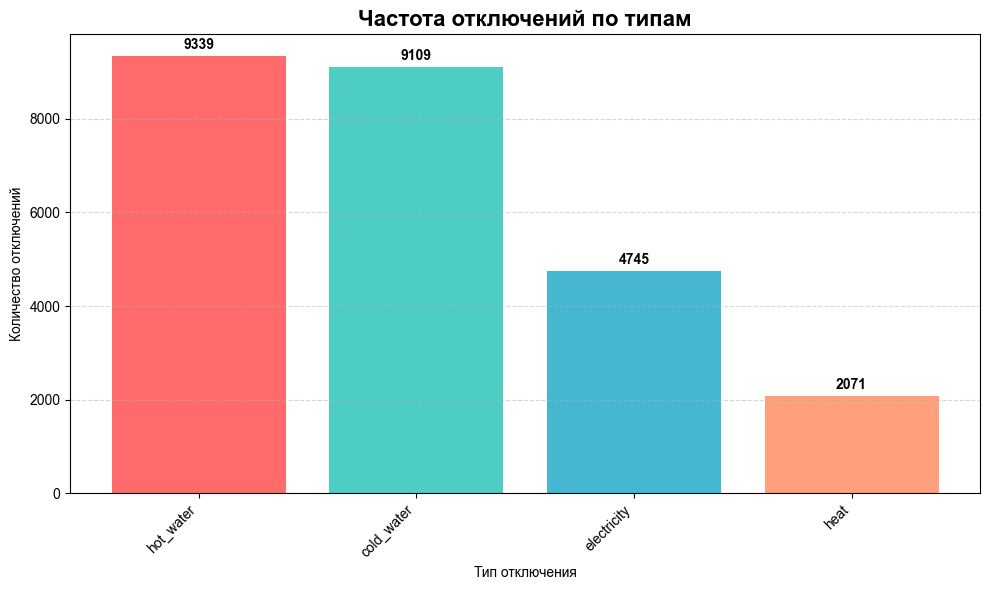

In [5]:
# --- 2.1. Функция анализа частоты по типам ---
DB_PATH = '../databases/dataset.db'
def analyze_outages_frequency(db_path):
    """Анализ частоты отключений по типам — печать таблицы и построение столбчатой диаграммы."""
    
    conn = sqlite3.connect(db_path)
    
    print("АНАЛИЗ ЧАСТОТЫ ОТКЛЮЧЕНИЙ ПО ТИПАМ")
    print("="*40)
    
    # Запрос без дат — только типы и количество
    query = """
    SELECT type, COUNT(*) as total_outages
    FROM blackouts
    WHERE start_date IS NOT NULL
    GROUP BY type
    ORDER BY total_outages DESC
    """
    
    try:
        df = pd.read_sql_query(query, conn)
        
        # ТАБЛИЦА (без колонок first_outage/last_outage)
        print("\nРЕЗУЛЬТАТЫ:")
        print(df.to_string(index=False))
        
        # ГРАФИК
        plt.figure(figsize=(10, 6))
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#9370DB', '#3CB371']
        bars = plt.bar(df['type'], df['total_outages'], color=colors[:len(df)])
        
        plt.title('Частота отключений по типам', fontsize=16, fontweight='bold')
        plt.ylabel('Количество отключений')
        plt.xlabel('Тип отключения')
        plt.xticks(rotation=45, ha='right')
        
        # Подписи значений над столбцами
        max_cnt = df['total_outages'].max() if not df.empty else 0
        for bar, count in zip(bars, df['total_outages']):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + max_cnt*0.01,
                     f'{int(height)}', ha='center', va='bottom', fontweight='bold')
        
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.savefig('outages_frequency.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    except Exception as e:
        print(f"❌ Ошибка при выполнении анализа частоты: {e}")
    
    finally:
        conn.close()

# --- 2.2. Запуск анализа частоты ---

analyze_outages_frequency(DB_PATH)

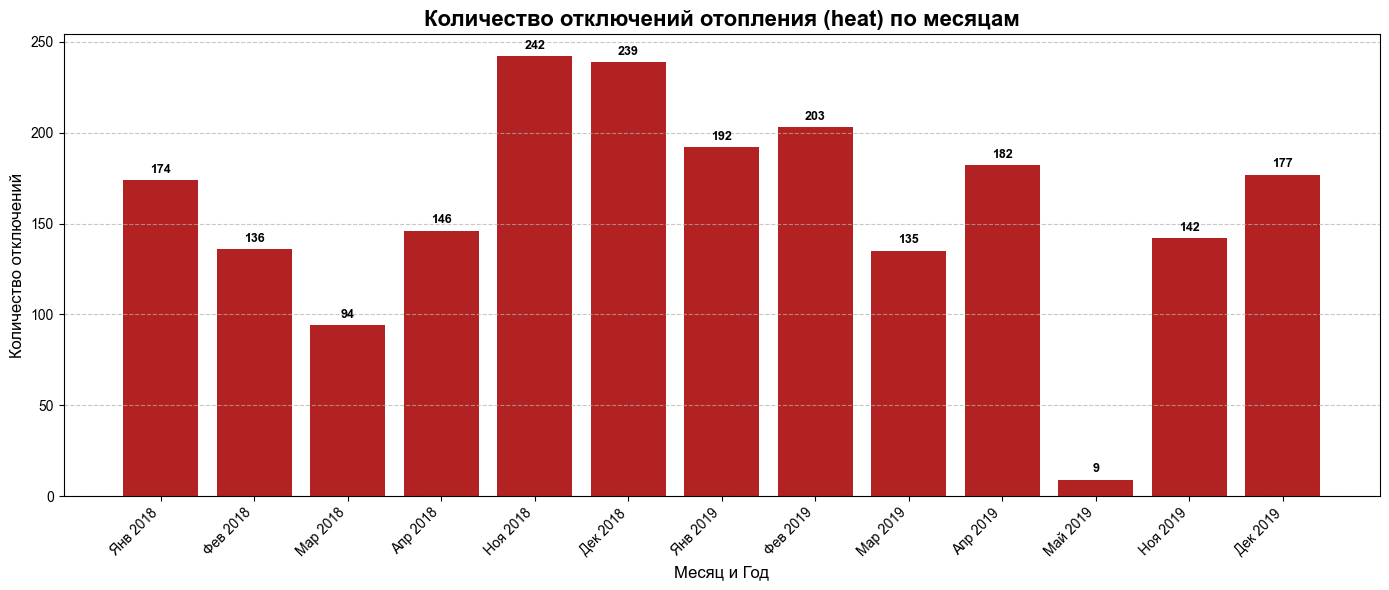

In [6]:
# --- 3.1. Функция анализа сезонности отопления ---
DB_PATH = '../databases/dataset.db'
def analyze_heat_outages_monthly(db_path):
    """Анализ количества отключений отопления по месяцам."""
    
    # Словарь для преобразования номера месяца в название на русском
    month_names = {
        '01': 'Январь', '02': 'Февраль', '03': 'Март', '04': 'Апрель',
        '05': 'Май', '06': 'Июнь', '07': 'Июль', '08': 'Август',
        '09': 'Сентябрь', '10': 'Октябрь', '11': 'Ноябрь', '12': 'Декабрь'
    }
    
    monthly_counts = defaultdict(int)

    try:
        # Подключение к базе данных
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        # SQL-запрос для выборки отключений с типом 'heat' и группировкой по году-месяцу
        query = """
        SELECT strftime('%Y-%m', start_date) AS month
        FROM blackouts
        WHERE type = 'heat' AND start_date IS NOT NULL
        ORDER BY month
        """

        cursor.execute(query)

        # Подсчет отключений по месяцам
        for row in cursor.fetchall():
            monthly_counts[row[0]] += 1

        conn.close()
        
    except sqlite3.Error as e:
        print(f"❌ Ошибка базы данных, используются примерные данные: {e}")
        # Используем примерные данные, если база данных недоступна или пуста
        monthly_counts = {
            '2023-01': 50, '2023-02': 65, '2023-03': 40, '2023-04': 20,
            '2023-10': 35, '2023-11': 70, '2023-12': 85,
            '2024-01': 55, '2024-02': 75, '2024-03': 45
        }

    # --- Подготовка данных для графика ---
    sorted_counts = sorted(monthly_counts.items())

    months_labels = []
    counts = []
    for month, count in sorted_counts:
        year, month_num = month.split('-')
        month_name = month_names.get(month_num, month_num)
        # Формат метки: "Янв 2023"
        months_labels.append(f"{month_name[:3]} {year}")
        counts.append(count)

    # --- Создание и сохранение диаграммы ---
    if not counts:
        print("Нет данных об отключениях отопления для построения графика.")
        return

    plt.figure(figsize=(14, 6))

    # Построение столбчатой диаграммы
    bars = plt.bar(months_labels, counts, color='#B22222') # Темно-красный цвет

    # Добавление значений над столбцами
    for bar in bars:
        yval = bar.get_height()
        # Добавляем небольшое смещение, пропорциональное максимальному значению
        plt.text(bar.get_x() + bar.get_width()/2, yval + max(counts)*0.01, round(yval), 
                 ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Настройка заголовка, осей и подписей
    plt.title('Количество отключений отопления (heat) по месяцам', fontsize=16, weight='bold')
    plt.xlabel('Месяц и Год', fontsize=12)
    plt.ylabel('Количество отключений', fontsize=12)

    # Поворот меток по оси X для лучшей читаемости
    plt.xticks(rotation=45, ha='right', fontsize=10)

    # Добавление сетки
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()

    filename = 'blackouts_heat_monthly_chart.png'
    plt.savefig(filename, dpi=300)
    plt.show()

# --- 3.2. Запуск анализа сезонности отопления ---

analyze_heat_outages_monthly(DB_PATH)

electricity: средняя длительность = 4.62 ч, записи = 4745 -> hist_electricity.png


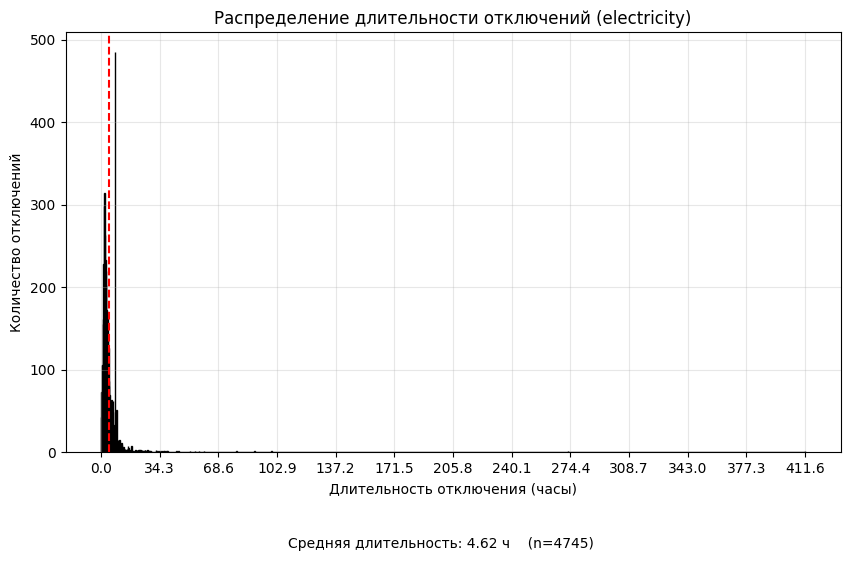

cold_water: средняя длительность = 10.28 ч, записи = 9109 -> hist_cold_water.png


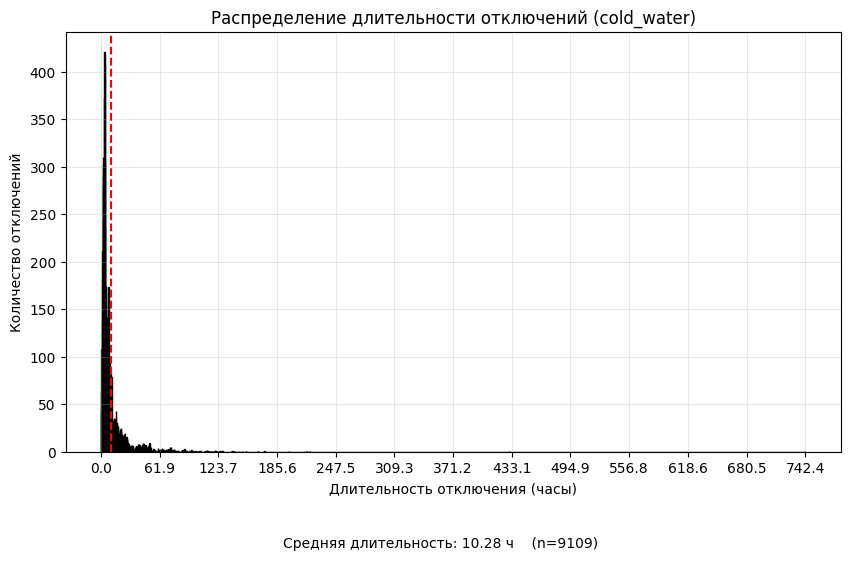

hot_water: средняя длительность = 69.68 ч, записи = 9339 -> hist_hot_water.png


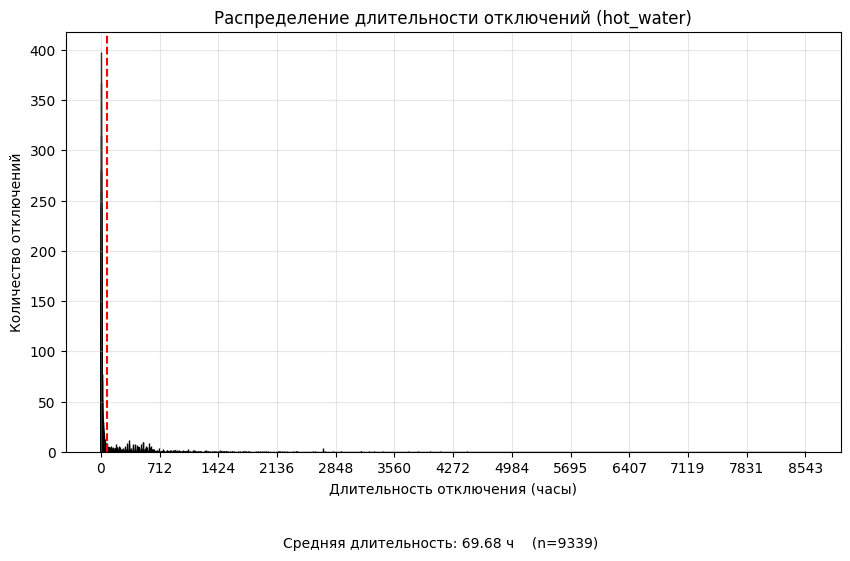

heat: средняя длительность = 11.01 ч, записи = 2071 -> hist_heat.png


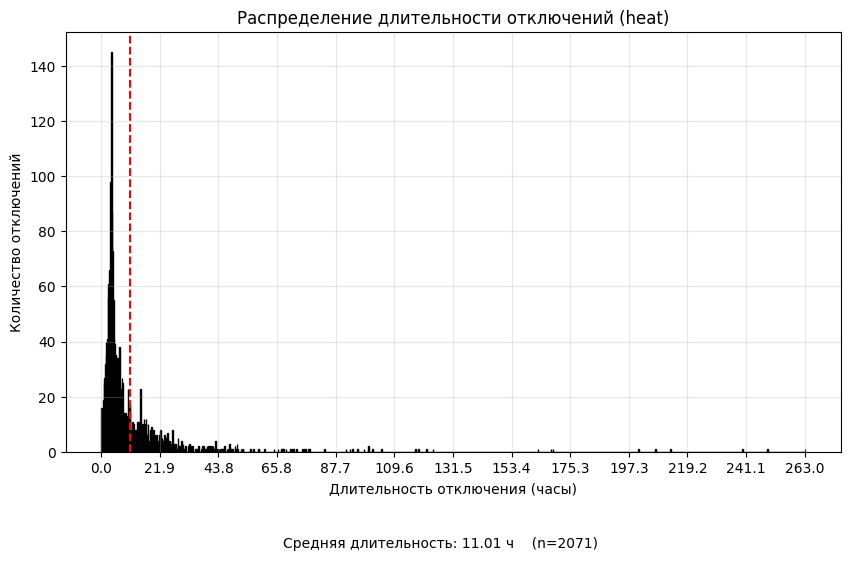

Все графики отображены.


In [1]:
# ...existing code...
import os
import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

DB_PATH = '../databases/dataset.db'
BIN_WIDTH_HOURS = 0.25  # 15 минут

def calculate_duration_hours(start_date, end_date):
    """Вернуть длительность в часах или None при некорректных/пустых датах."""
    if not start_date or not end_date:
        return None
    for fmt in ('%Y-%m-%d %H:%M:%S', '%Y-%m-%d'):
        try:
            start = datetime.strptime(start_date, fmt)
            end = datetime.strptime(end_date, fmt)
            duration_h = (end - start).total_seconds() / 3600.0
            return duration_h if duration_h >= 0 else 0.0
        except (ValueError, TypeError):
            continue
    return None

def safe_filename(s):
    return "".join(c if c.isalnum() or c in '._-' else '_' for c in str(s)).strip('_')

def plot_histogram_for_type(blackout_type, durations):
    max_val = max(48, max(durations))  # минимум 48 часов охвата
    bins = np.arange(0, max_val + BIN_WIDTH_HOURS, BIN_WIDTH_HOURS)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(durations, bins=bins, edgecolor='black', color='#69b3a2')
    mean_hours = float(np.mean(durations))

    # Вертикальная линия среднего
    ax.axvline(mean_hours, color='red', linestyle='--', linewidth=1.5)

    # Подписи и сетка
    ax.set_title(f'Распределение длительности отключений ({blackout_type})')
    ax.set_xlabel('Длительность отключения (часы)')
    ax.set_ylabel('Количество отключений')
    ax.grid(True, alpha=0.3)

    # Настройка делений по X для читаемости
    xticks = np.linspace(0, max_val, num=13)
    ax.set_xticks(np.round(xticks, 2))

    # Оставляем место внизу и добавляем подпись среднего под гистограммой
    plt.subplots_adjust(bottom=0.18)
    plt.figtext(0.5, 0.02, f'Средняя длительность: {mean_hours:.2f} ч    (n={len(durations)})',
                ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    # Сохранение и показ
    outname = f'hist_{safe_filename(blackout_type)}.png'
    plt.savefig(outname, dpi=150, bbox_inches='tight')
    print(f"{blackout_type}: средняя длительность = {mean_hours:.2f} ч, записи = {len(durations)} -> {outname}")
    plt.show()
    plt.close(fig)

def main(db_path=DB_PATH):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    try:
        cursor.execute("SELECT DISTINCT type FROM blackouts")
        types = [row[0] for row in cursor.fetchall()]

        for blackout_type in types:
            cursor.execute("""
                SELECT start_date, end_date
                FROM blackouts
                WHERE type = ?
            """, (blackout_type,))

            durations = []
            for row in cursor.fetchall():
                start_date, end_date = row
                dur = calculate_duration_hours(start_date, end_date)
                if dur is not None:
                    durations.append(dur)

            if not durations:
                print(f"Нет данных для типа '{blackout_type}'")
                continue

            plot_histogram_for_type(blackout_type, durations)

    finally:
        conn.close()
        print("Все графики отображены.")

if __name__ == '__main__':
    main()
# ...existing code...